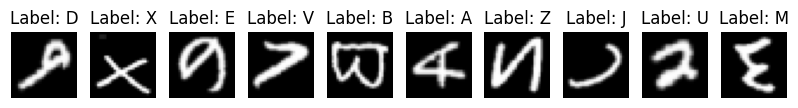


Training with sgd optimizer...

Epoch 1/10, Loss: 2.1625
Epoch 2/10, Loss: 1.3187
Epoch 3/10, Loss: 1.1498
Epoch 4/10, Loss: 1.0624
Epoch 5/10, Loss: 1.0000
Epoch 6/10, Loss: 0.9489
Epoch 7/10, Loss: 0.9038
Epoch 8/10, Loss: 0.8639
Epoch 9/10, Loss: 0.8268
Epoch 10/10, Loss: 0.7929
Validation Accuracy with sgd: 77.17%
Test Accuracy with sgd: 77.27%


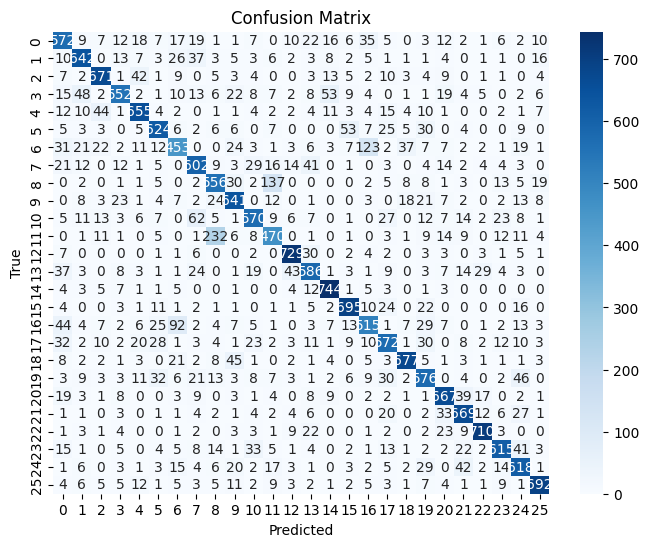

Cross Entropy Loss: 0.7921
Mean Squared Error Loss: 10.6127

Training with momentum optimizer...

Epoch 1/10, Loss: 1.1772
Epoch 2/10, Loss: 0.6842
Epoch 3/10, Loss: 0.5405
Epoch 4/10, Loss: 0.4636
Epoch 5/10, Loss: 0.4143
Epoch 6/10, Loss: 0.3796
Epoch 7/10, Loss: 0.3516
Epoch 8/10, Loss: 0.3314
Epoch 9/10, Loss: 0.3141
Epoch 10/10, Loss: 0.2984
Validation Accuracy with momentum: 88.86%
Test Accuracy with momentum: 88.95%


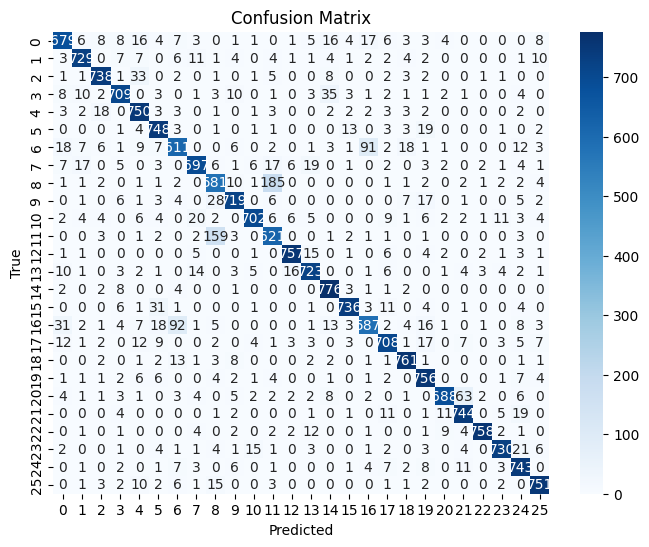

Cross Entropy Loss: 0.3572
Mean Squared Error Loss: 23.5877

Training with nesterov optimizer...

Epoch 1/10, Loss: 1.1829
Epoch 2/10, Loss: 0.6812
Epoch 3/10, Loss: 0.5329
Epoch 4/10, Loss: 0.4574
Epoch 5/10, Loss: 0.4090
Epoch 6/10, Loss: 0.3763
Epoch 7/10, Loss: 0.3497
Epoch 8/10, Loss: 0.3284
Epoch 9/10, Loss: 0.3105
Epoch 10/10, Loss: 0.2959
Validation Accuracy with nesterov: 88.49%
Test Accuracy with nesterov: 88.73%


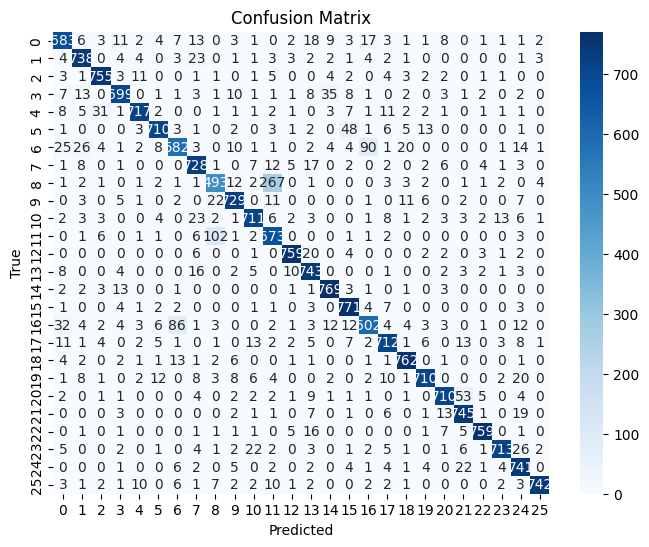

Cross Entropy Loss: 0.3578
Mean Squared Error Loss: 22.5338

Training with rmsprop optimizer...

Epoch 1/10, Loss: 0.7236
Epoch 2/10, Loss: 0.4435
Epoch 3/10, Loss: 0.3850
Epoch 4/10, Loss: 0.3550
Epoch 5/10, Loss: 0.3348
Epoch 6/10, Loss: 0.3242
Epoch 7/10, Loss: 0.3142
Epoch 8/10, Loss: 0.3102
Epoch 9/10, Loss: 0.3063
Epoch 10/10, Loss: 0.3052
Validation Accuracy with rmsprop: 88.07%
Test Accuracy with rmsprop: 87.88%


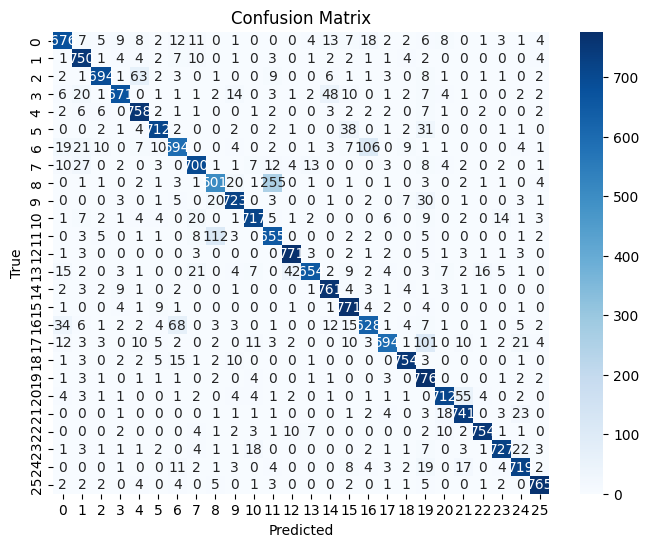

Cross Entropy Loss: 0.4994
Mean Squared Error Loss: 1966.2668

Training with adam optimizer...

Epoch 1/10, Loss: 0.7163
Epoch 2/10, Loss: 0.4275
Epoch 3/10, Loss: 0.3627
Epoch 4/10, Loss: 0.3286
Epoch 5/10, Loss: 0.3055
Epoch 6/10, Loss: 0.2869
Epoch 7/10, Loss: 0.2704
Epoch 8/10, Loss: 0.2586
Epoch 9/10, Loss: 0.2498
Epoch 10/10, Loss: 0.2396
Validation Accuracy with adam: 89.17%
Test Accuracy with adam: 89.19%


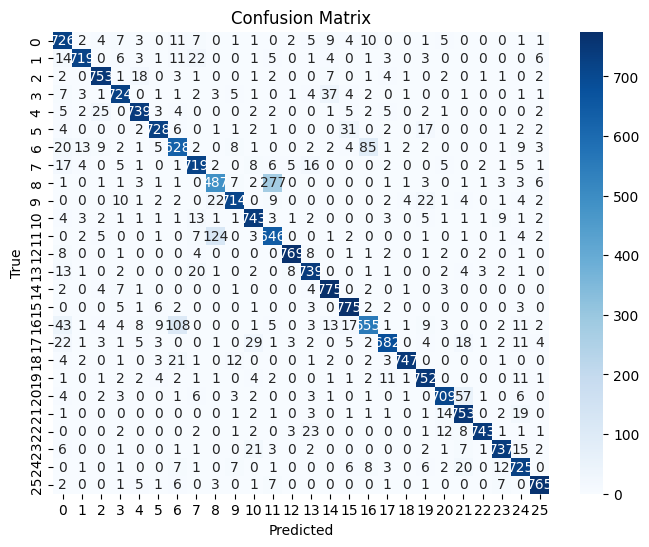

Cross Entropy Loss: 0.4011
Mean Squared Error Loss: 219.2727

Final Results Comparison:
sgd: Val Acc = 77.17%, Test Acc = 77.27%
momentum: Val Acc = 88.86%, Test Acc = 88.95%
nesterov: Val Acc = 88.49%, Test Acc = 88.73%
rmsprop: Val Acc = 88.07%, Test Acc = 87.88%
adam: Val Acc = 89.17%, Test Acc = 89.19%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load EMNIST Letters dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.EMNIST(root='./data', split='letters', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.EMNIST(root='./data', split='letters', train=False, transform=transform, download=True)

# Adjust labels to be in range (0-25) instead of (1-26)
train_dataset.targets -= 1
test_dataset.targets -= 1

# Split train into training and validation
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Hyperparameters
batch_size = 32
num_epochs = 10
learning_rate = 1e-3
hidden_layers = [32,64,128]  # Flexible hidden layers
activation_function = nn.ReLU  # Change to nn.Sigmoid if needed
weight_init = "xavier"  # Options: "random", "xavier"
optimizers_to_test = ["sgd", "momentum", "nesterov", "rmsprop", "adam"]  # List of optimizers

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Plot Sample Images
def plot_sample_images(dataset, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(10, 2))
    for i in range(num_images):
        image, label = dataset[i]
        axes[i].imshow(image.squeeze(), cmap="gray")
        axes[i].set_title(f"Label: {chr(label + 65)}")  # Convert label (0-25) to A-Z
        axes[i].axis("off")
    plt.show()

plot_sample_images(train_dataset)

# Define Neural Network
class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size, activation_fn):
        super(FeedForwardNN, self).__init__()
        layers = []
        prev_size = input_size
        for layer_size in hidden_layers:
            layers.append(nn.Linear(prev_size, layer_size))
            layers.append(activation_fn())
            prev_size = layer_size
        layers.append(nn.Linear(prev_size, output_size))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Initialize Model Weights
def initialize_weights(model, init_type):
    for layer in model.network:
        if isinstance(layer, nn.Linear):
            if init_type == "xavier":
                nn.init.xavier_uniform_(layer.weight)
            else:
                nn.init.uniform_(layer.weight, -0.1, 0.1)

# Define Optimizer
def get_optimizer(opt_name, model, lr):
    if opt_name == "sgd":
        return optim.SGD(model.parameters(), lr=lr)
    elif opt_name == "momentum":
        return optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    elif opt_name == "nesterov":
        return optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)
    elif opt_name == "rmsprop":
        return optim.RMSprop(model.parameters(), lr=lr)
    elif opt_name == "adam":
        return optim.Adam(model.parameters(), lr=lr)

# Loss Function (Cross-Entropy)
criterion = nn.CrossEntropyLoss()

# Train Model
def train_model(model, train_loader, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for images, labels in train_loader:
            images = images.view(-1, 28*28).to(device)
            labels = labels.to(device)  # Labels already shifted (0-25)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}")
    return model

# Evaluate Model
def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.view(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Plot Confusion Matrix
def plot_confusion_matrix(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.view(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Compare Cross Entropy vs. MSE Loss
mse_criterion = nn.MSELoss()
def compare_losses(model, loader):
    model.eval()
    ce_loss = 0
    mse_loss = 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.view(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs = model(images)
            ce_loss += criterion(outputs, labels).item()
            mse_loss += mse_criterion(outputs, torch.nn.functional.one_hot(labels, num_classes=26).float().to(device)).item()
    print(f"Cross Entropy Loss: {ce_loss / len(loader):.4f}")
    print(f"Mean Squared Error Loss: {mse_loss / len(loader):.4f}")

# Store results
results = {}

for opt_name in optimizers_to_test:
    print(f"\nTraining with {opt_name} optimizer...\n")

    # Reinitialize model and weights
    model = FeedForwardNN(28*28, hidden_layers, 26, activation_function).to(device)  # 26 output classes
    initialize_weights(model, weight_init)

    # Get optimizer
    optimizer = get_optimizer(opt_name, model, learning_rate)

    # Train model
    trained_model = train_model(model, train_loader, optimizer, num_epochs)

    # Evaluate model
    val_acc = evaluate_model(trained_model, val_loader)
    test_acc = evaluate_model(trained_model, test_loader)

    # Store results
    results[opt_name] = {"Validation Accuracy": val_acc, "Test Accuracy": test_acc}
    print(f"Validation Accuracy with {opt_name}: {val_acc*100:.2f}%")
    print(f"Test Accuracy with {opt_name}: {test_acc*100:.2f}%")

    # Plot confusion matrix for each optimizer
    plot_confusion_matrix(trained_model, test_loader)

    # Compare losses
    compare_losses(trained_model, test_loader)

# Display final results
print("\nFinal Results Comparison:")
for opt, metrics in results.items():
    print(f"{opt}: Val Acc = {metrics['Validation Accuracy']*100:.2f}%, Test Acc = {metrics['Test Accuracy']*100:.2f}%")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load EMNIST Letters dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.EMNIST(root='./data', split='letters', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.EMNIST(root='./data', split='letters', train=False, transform=transform, download=True)

# Adjust labels to be in range (0-25) instead of (1-26)
train_dataset.targets -= 1
test_dataset.targets -= 1

# Split train into training and validation
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Hyperparameters
num_epochs_list = [5, 10]
hidden_layers_list = [[32, 64, 128], [32, 64, 128, 256], [32, 64, 128, 256, 512]]
weight_decay_list = [0, 0.0005, 0.5]
learning_rate_list = [1e-3, 1e-4]
optimizers_to_test = ["sgd", "momentum", "nesterov", "rmsprop", "adam", "nadam"]
batch_sizes = [16, 32, 64]
weight_init_methods = ["random", "xavier"]
activation_functions = [nn.Sigmoid, nn.ReLU]

# Data Loaders
def get_dataloaders(batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader

# Define Neural Network
class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size, activation_fn):
        super(FeedForwardNN, self).__init__()
        layers = []
        prev_size = input_size
        for layer_size in hidden_layers:
            layers.append(nn.Linear(prev_size, layer_size))
            layers.append(activation_fn())
            prev_size = layer_size
        layers.append(nn.Linear(prev_size, output_size))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Initialize Model Weights
def initialize_weights(model, init_type):
    for layer in model.network:
        if isinstance(layer, nn.Linear):
            if init_type == "xavier":
                nn.init.xavier_uniform_(layer.weight)
            else:
                nn.init.uniform_(layer.weight, -0.1, 0.1)

# Define Optimizer
def get_optimizer(opt_name, model, lr, weight_decay):
    if opt_name == "sgd":
        return optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif opt_name == "momentum":
        return optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    elif opt_name == "nesterov":
        return optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True, weight_decay=weight_decay)
    elif opt_name == "rmsprop":
        return optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif opt_name == "adam":
        return optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif opt_name == "nadam":
        return optim.NAdam(model.parameters(), lr=lr, weight_decay=weight_decay)

# Loss Function (Cross-Entropy)
criterion = nn.CrossEntropyLoss()

# Train Model
def train_model(model, train_loader, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for images, labels in train_loader:
            images = images.view(-1, 28*28).to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}")
    return model

# Evaluate Model
def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.view(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Running Experiments
results = {}

for num_epochs in num_epochs_list:
    for hidden_layers in hidden_layers_list:
        for weight_decay in weight_decay_list:
            for learning_rate in learning_rate_list:
                for optimizer_name in optimizers_to_test:
                    for batch_size in batch_sizes:
                        for weight_init in weight_init_methods:
                            for activation_fn in activation_functions:
                                print(f"\nTraining with {optimizer_name}, LR={learning_rate}, Weight Decay={weight_decay}, Batch Size={batch_size}, Activation={activation_fn.__name__}, Init={weight_init}\n")

                                # Load Data
                                train_loader, val_loader, test_loader = get_dataloaders(batch_size)

                                # Initialize Model
                                model = FeedForwardNN(28*28, hidden_layers, 26, activation_fn).to(device)
                                initialize_weights(model, weight_init)

                                # Get Optimizer
                                optimizer = get_optimizer(optimizer_name, model, learning_rate, weight_decay)

                                # Train Model
                                trained_model = train_model(model, train_loader, optimizer, num_epochs)

                                # Evaluate Model
                                val_acc = evaluate_model(trained_model, val_loader)
                                test_acc = evaluate_model(trained_model, test_loader)

                                # Store results
                                config = f"{optimizer_name}_LR{learning_rate}_WD{weight_decay}_BS{batch_size}_{activation_fn.__name__}_{weight_init}"
                                results[config] = {"Validation Accuracy": val_acc, "Test Accuracy": test_acc}
                                print(f"Validation Accuracy: {val_acc*100:.2f}%, Test Accuracy: {test_acc*100:.2f}%")

# Display final results
print("\nFinal Results Comparison:")
for config, metrics in results.items():
    print(f"{config}: Val Acc = {metrics['Validation Accuracy']*100:.2f}%, Test Acc = {metrics['Test Accuracy']*100:.2f}%")
